In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Physics parameters 
Te = 3          # Constant electron temperature
A0 = 1/np.pi
eta= 1.0e-8

# Numerical settings
L  = np.sqrt(2) # Length of the simulation region
n  = 200        # numebr of grids
ng = 2          # number of ghost grids for 5-points central scheme
h  = L/n        # unit size 
T  = 3.0        # simulation time
nt = 3000        # number of time steps
dt = T/nt       # time step

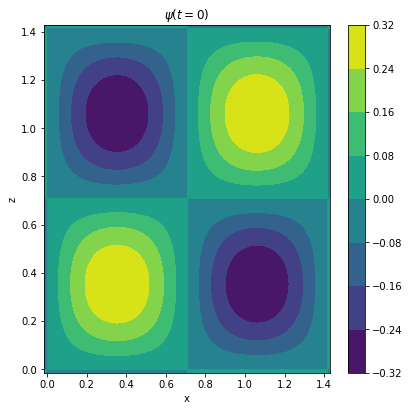

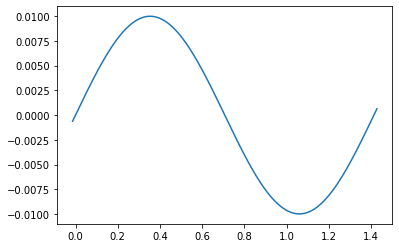

In [12]:
# Initial condition
rho1 = np.ones([n+2*ng+1, n+2*ng+1])  # Initial density
vx1  = np.zeros([n+2*ng+1, n+2*ng+1])
vz1  = np.zeros([n+2*ng+1, n+2*ng+1])
psi1 = np.zeros([n+2*ng+1, n+2*ng+1])

for i in range(n+1):
    for j in range(n+1):
        x = j*h 
        z = i*h 
        psi1[i+2,j+2] = A0*np.sin(2*np.pi*x/L)*np.sin(2*np.pi*z/L)

# Doubly-preriodic BC       
# Top
rho1[0]    = rho1[-5]
rho1[1]    = rho1[-4]
psi1[0]    = psi1[-5]
psi1[1]    = psi1[-4]
vx1[0]     = vx1[-5]
vx1[1]     = vx1[-4]
vz1[0]     = vz1[-5]
vz1[1]     = vz1[-4]
# Bottom 
rho1[-2]   = rho1[3]
rho1[-1]   = rho1[4]
psi1[-2]   = psi1[3]
psi1[-1]   = psi1[4]
vx1[-2]    = vx1[3]
vx1[-1]    = vx1[4]
vz1[-2]    = vz1[3]
vz1[-1]    = vz1[4]
# Left 
rho1[:,0]  = rho1[:,-5]  
rho1[:,1]  = rho1[:,-4]  
psi1[:,0]  = psi1[:,-5] 
psi1[:,1]  = psi1[:,-4]
vx1[:,0]   = vx1[:,-5]  
vx1[:,1]   = vx1[:,-4]  
vz1[:,0]   = vz1[:,-5] 
vz1[:,1]   = vz1[:,-4]
# Right 
rho1[:,-2] = rho1[:,3]
rho1[:,-1] = rho1[:,4]
psi1[:,-2] = psi1[:,3]
psi1[:,-1] = psi1[:,4]
vx1[:,-2]  = vx1[:,3]
vx1[:,-1]  = vx1[:,4]
vz1[:,-2]  = vz1[:,3]
vz1[:,-1]  = vz1[:,4]

plt.figure(figsize=[6.4,6.4])
x = np.linspace(0-2*h, L+2*h, n+5)
z = np.linspace(0-2*h, L+2*h, n+5)
cont = plt.contourf(x, z, psi1)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\psi(t=0)$')
#plt.savefig('psi0.png')

plt.figure()
plt.plot(z, psi1[:,3])

In [13]:
# 1st-order partial derivatives
def px(f, dx):
    return (-f[2:-2,4:]+8*f[2:-2,3:-1]-8*f[2:-2,1:-3]+f[2:-2,:-4]) / (12*dx)

def pz(f, dz):
    return (-f[4:,2:-2]+8*f[3:-1,2:-2]-8*f[1:-3,2:-2]+f[:-4,2:-2]) / (12*dz)

# 2nd-order partial derivatives
def pxx(f, dx):
    return (-f[2:-2,4:]+16*f[2:-2,3:-1]-30*f[2:-2,2:-2]+16*f[2:-2,1:-3]-f[2:-2,:-4]) / (12*dx**2)

def pzz(f, dz):
    return (-f[4:,2:-2]+16*f[3:-1,2:-2]-30*f[2:-2,2:-2]+16*f[1:-3,2:-2]-f[:-4,2:-2]) / (12*dz**2)

In [14]:
def f_rho(rho, vx, vz, dx, dz, dt, k):
    s1 = - np.multiply(rho[2:-2,2:-2], px(vx,dx)+pz(vx,dz))
    a1 = px(vx,dx)
    a2 = pz(vx,dz)
    if (k%20==0):
        print('px:', a1[0,0], 'pz:', a2[0,0])     
        plt.figure(figsize=[6.4,9.6])
        x = np.linspace(0, np.sqrt(2), 201)
        z = np.linspace(0, np.sqrt(2), 201)
        plt.subplot(211)
        plt.plot(x, a1[2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(x, a2[2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('x', fontsize=24)
        plt.title('t='+str(k*dt), fontsize=24)
        plt.legend(fontsize=18)
        plt.subplot(212)
        plt.plot(z, a1[:,2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(z, a2[:,2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('z', fontsize=24)
        plt.legend(fontsize=18)
        plt.tight_layout()
        plt.savefig('oscillation_SE_'+str(k)+'.png')
    
    s2 = - np.multiply(vx[2:-2,2:-2], px(rho,dx)) - np.multiply(vz[2:-2,2:-2], pz(rho,dz))
    return (s1+s2)*dt

def f_vx(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vx,dx)) - np.multiply(vz[2:-2,2:-2], pz(vx,dz))
    s2 = - np.divide(2*Te*px(rho,dx), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(px(psi,dx), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_vz(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vz,dx)) - np.multiply(vz[2:-2,2:-2], pz(vz,dz))
    s2 = - np.divide(2*Te*pz(rho,dz), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(pz(psi,dz), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_psi(vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(psi,dx)) - np.multiply(vz[2:-2,2:-2], pz(psi,dz))
    s2 = eta * (pxx(psi,dx)+pzz(psi,dz))
    return (s1+s2)*dt

0
px: 0.0 pz: 5.038946757408047e-16
rho: 1.0000789567907908 0.0
psi: 0.318309886058127 0.318309886058127


1
rho: 1.0001578824124104 0.9998363889756835
psi: 0.3183098859324434 0.3183098859324434


2
rho: 1.0002367830689687 0.9997583221087221
psi: 0.3183098858067301 0.3183098858067301


3
rho: 1.0003156649504223 0.9996800784382174
psi: 0.31830988568097707 0.31830988568097707


4
rho: 1.0003945342379899 0.9996017370697199
psi: 0.31830988555517437 0.31830988555517437


5
rho: 1.0004733971095383 0.9995233692620608
psi: 0.318309885429312 0.318309885429312


6
rho: 1.0005522597449554 0.9994450219525959
psi: 0.31830988530337995 0.31830988530337995


7
rho: 1.0006311283315177 0.999366724896454
psi: 0.31830988517736813 0.31830988517736813


8
rho: 1.000710009069266 0.9992884967038334
psi: 0.3183098850512664 0.3183098850512664


9
rho: 1.000788908176399 0.9992103488388446
psi: 0.31830988492506457 0.31830988492506457


10
rho: 1.0008678318946977 0.9991322881992374
psi: 0.3183098847987524 0.318309

rho: 1.0101941012654987 0.9924166479564908
psi: 0.31830987018544593 0.31830987018544593


101
rho: 1.0104224390073047 0.9923443401212738
psi: 0.31830986988756793 0.31830986988756793


102
rho: 1.0106912294953043 0.9922720528758583
psi: 0.31830986957832474 0.31830986957832474


103
rho: 1.0109775584734508 0.992199785025069
psi: 0.31830986925657123 0.31830986925657123


104
rho: 1.011278641292955 0.9921275353624813
psi: 0.3183098689209963 0.3183098689209963


105
rho: 1.0115945632154029 0.9920553026702413
psi: 0.3183098685700927 0.3183098685700927


106
rho: 1.0119250039767285 0.9919830857188787
psi: 0.31830986820212087 0.31830986820212087


107
rho: 1.012280575767617 0.9919108832671147
psi: 0.31830986781506476 0.31830986781506476


108
rho: 1.0126594179382358 0.9918386940616635
psi: 0.31830986740657924 0.31830986740657924


109
rho: 1.013050706995812 0.991766516837027
psi: 0.31830986697392666 0.31830986697392666


110
rho: 1.0134511293269168 0.9916943503152835
psi: 0.31830986651390103 0

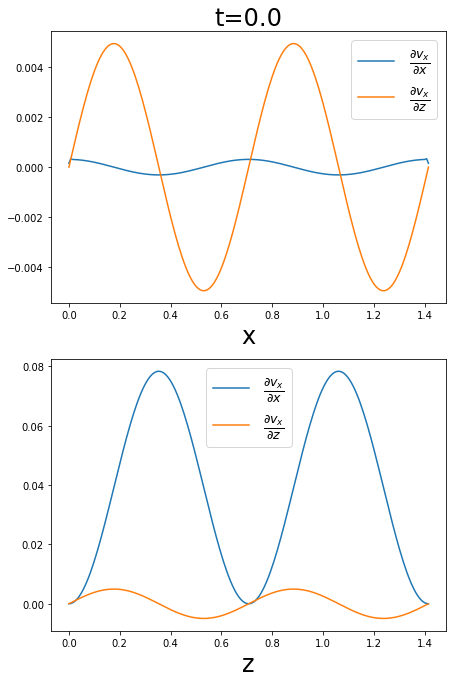

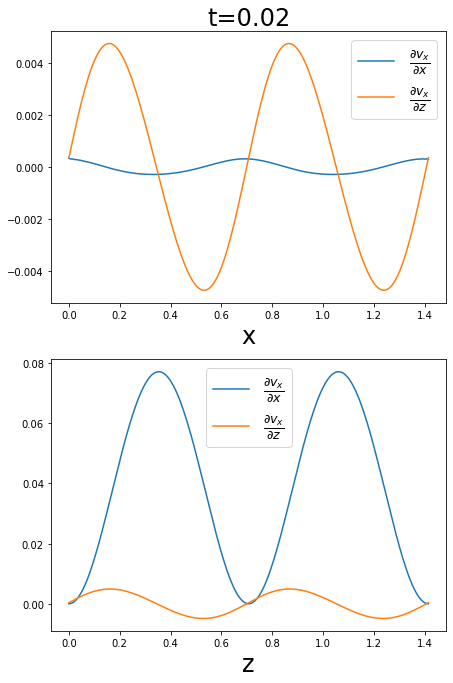

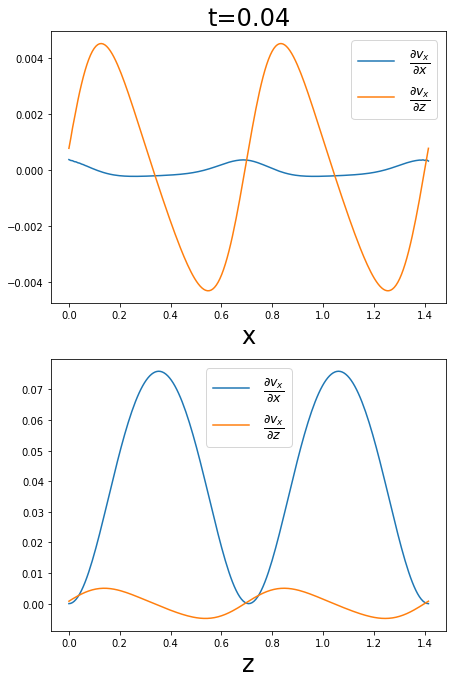

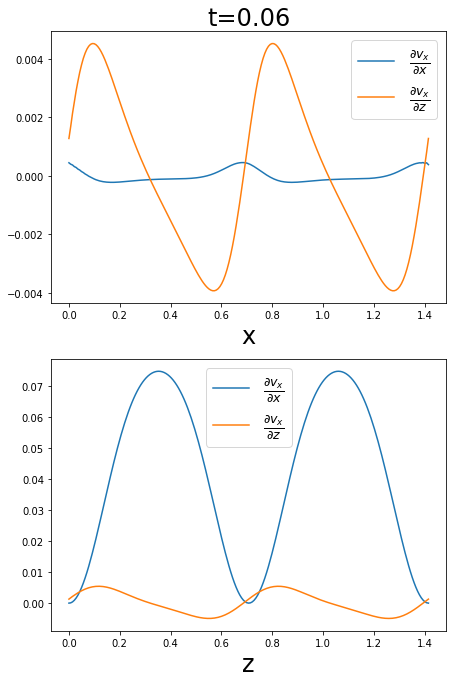

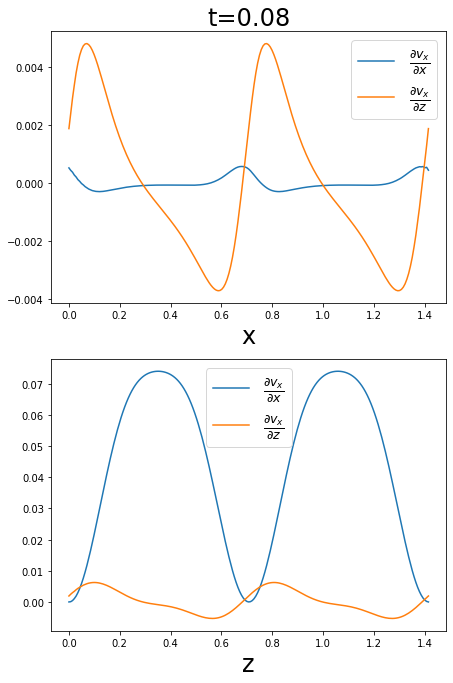

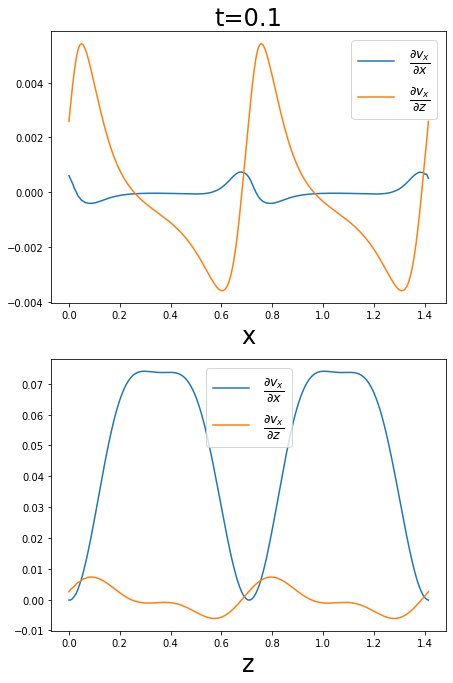

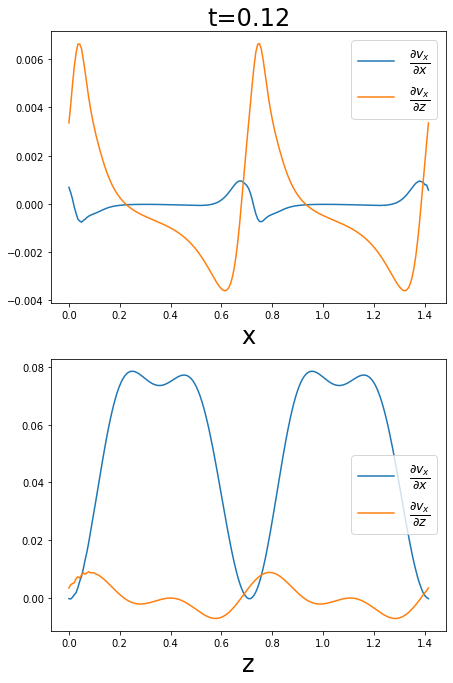

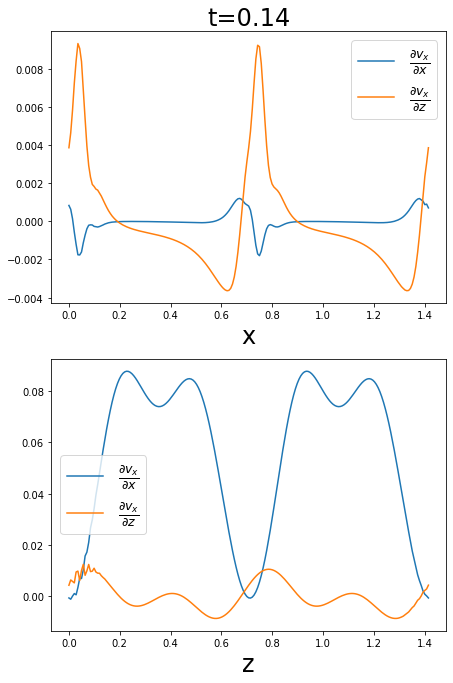

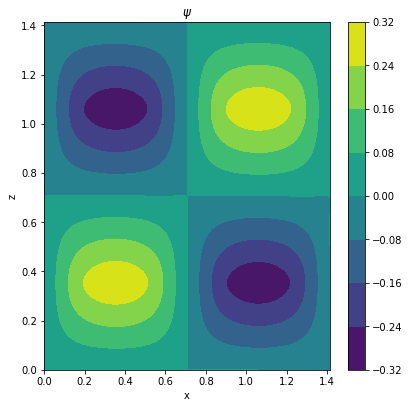

In [15]:
# Symplectic Euler Stepper
vx2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
vz2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
rho2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
psi2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1

for k in range(141):
    print(k)
    
    vx2[2:-2,2:-2] = vx1[2:-2,2:-2] + f_vx(rho1, vx1, vz1, psi1, h, h, dt)
    vz2[2:-2,2:-2] = vz1[2:-2,2:-2] + f_vz(rho1, vx1, vz1, psi1, h, h, dt)
    
    rho2[2:-2,2:-2] = rho1[2:-2,2:-2] + f_rho(rho1, vx2, vz2, h, h, dt, k)
    psi2[2:-2,2:-2] = psi1[2:-2,2:-2] + f_psi(vx2, vz2, psi1, h, h, dt)
    print('rho:', np.amax(rho2), np.amin(rho2))
    print('psi:', np.amax(psi2), np.amax(psi2))
    print('\n')
    
    # Top
    rho2[0]    = rho2[-5]
    rho2[1]    = rho2[-4]
    psi2[0]    = psi2[-5]
    psi2[1]    = psi2[-4]
    vx2[0]     = vx2[-5]
    vx2[1]     = vx2[-4]
    vz2[0]     = vz2[-5]
    vz2[1]     = vz2[-4]
    # Bottom 
    rho2[-2]   = rho2[3]
    rho2[-1]   = rho2[4]
    psi2[-2]   = psi2[3]
    psi2[-1]   = psi2[4]
    vx2[-2]    = vx2[3]
    vx2[-1]    = vx2[4]
    vz2[-2]    = vz2[3]
    vz2[-1]    = vz2[4]
    # Left 
    rho2[:,0]  = rho2[:,-5]  
    rho2[:,1]  = rho2[:,-4]  
    psi2[:,0]  = psi2[:,-5] 
    psi2[:,1]  = psi2[:,-4]
    vx2[:,0]   = vx2[:,-5]  
    vx2[:,1]   = vx2[:,-4]  
    vz2[:,0]   = vz2[:,-5] 
    vz2[:,1]   = vz2[:,-4]
    # Right 
    rho2[:,-2] = rho2[:,3]
    rho2[:,-1] = rho2[:,4]
    psi2[:,-2] = psi2[:,3]
    psi2[:,-1] = psi2[:,4]
    vx2[:,-2]  = vx2[:,3]
    vx2[:,-1]  = vx2[:,4]
    vz2[:,-2]  = vz2[:,3]
    vz2[:,-1]  = vz2[:,4]

    
    # Update the result
    rho1 = rho2
    vx2  = vx2
    vz1  = vz2
    psi1 = psi2
    
    if (k==140):
        x = np.linspace(0, L, n+1)
        z = np.linspace(0, L, n+1)
        plt.figure(figsize=[6.4,6.4])
        cont = plt.contourf(x, z, psi1[2:-2,2:-2])
        cbar = plt.colorbar(cont)
        plt.xlabel('x')
        plt.ylabel('z')
        plt.title(r'$\psi$')
        plt.savefig('psi1_SE_'+str(k)+'.png')

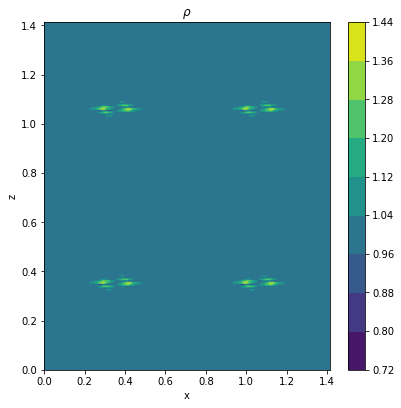

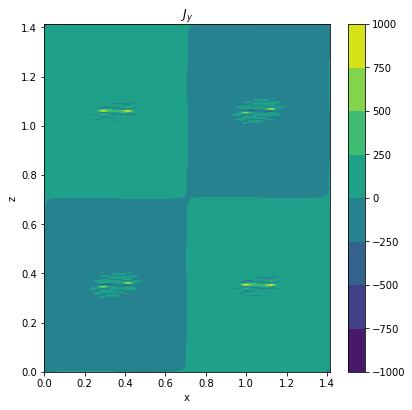

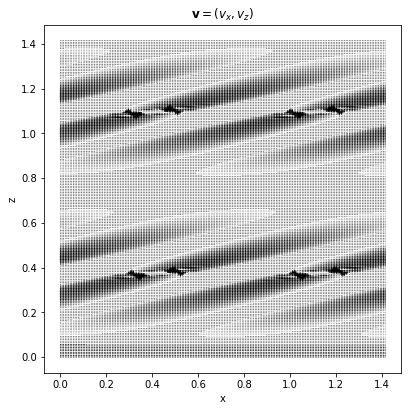

In [16]:
x = np.linspace(0, L, n+1)
z = np.linspace(0, L, n+1)

plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, rho1[2:-2,2:-2])
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\rho$')
plt.savefig('rho_SE_'+str(k)+'.png')

jy = pxx(psi1,h) + pzz(psi1,h)
plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, jy)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$J_y$')
plt.savefig('jy_SE_'+str(k)+'.png')

X, Z = np.meshgrid(x,z)
plt.figure(figsize=[6.4,6.4])
plt.quiver(X, Z, vx1, vz1)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\mathbf{v}=(v_x,v_z)$')
plt.savefig('v_SE_'+str(k)+'.png')